# Computing the Hessian for a toy stellar spectral model.

gully, on a Saturday in Mountain View  

In this notebook we use the same toy stellar spectrum model as before:

$$\mathbf{f(\vec{\theta})} = f_\lambda(T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}])$$


The goal of this notebook is to show that we can compute the [Hessian Matrix](https://en.wikipedia.org/wiki/Hessian_matrix) of the spectrum.  That is, the second order partial derivatives of the spectrum, $f_\lambda$ with respect to each permutation of parameters, $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}]$.   

See the wiki!

We'll use [jax](https://github.com/google/jax) as before.

In [1]:
#import numpy as np
import jax.numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The data exist as a table of wavelength, flux, and flux uncertainty.  
You can think of the wavelength values as corresponding to the near-IR in micron.

In [3]:
wl = np.linspace(2.0, 2.4, 300)

/Users/obsidian/anaconda3/envs/TgiF/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Everything is the same as before.

In [4]:
def line_profile(location, depth, width):
    """Make a spectral line"""
    return depth * np.exp(-0.5*((wl-location)/width)**2)

In [5]:
def synthetic_spectrum(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 
    amp1 = 0.6*np.exp(-((teff-2700)/500)**2)
    line1 = line_profile(2.1, amp1, 0.01)
    
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, 0.3, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

In [6]:
flux = synthetic_spectrum((2700, 3.5, 0.0))

Next step: use jax to get the Hessian through [twice-applying the Jacobian](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html).

In [7]:
from jax import grad, jit, vmap, jacfwd, jacrev

In [8]:
%%time 
hessian_rf = jacrev(jacfwd(synthetic_spectrum))((2900.0, 3.7, 0.3))

CPU times: user 1.85 s, sys: 87.2 ms, total: 1.94 s
Wall time: 1.82 s


In [9]:
%%time 
hessian_fr = jacfwd(jacrev(synthetic_spectrum))((2900.0, 3.7, 0.3))

CPU times: user 1.34 s, sys: 28.9 ms, total: 1.37 s
Wall time: 1.33 s


They take about the same amount of time, which is interesting.  Also a somewhat long amount of time compared to the Jacobians...

In [10]:
hessian_fr[0][0].shape

(300,)

In [11]:
labels = [[r'$\frac{\partial^2 f_\lambda}{\partial T^2_{\mathrm{eff} }}$',
          r'$\frac{\partial^2 f_\lambda}{\partial \log{g} \, \partial T_{\mathrm{eff} }}$',
          r'$\frac{\partial f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}] \, \partial T_{\mathrm{eff} } }$'],
            [r'$\frac{\partial^2 f_\lambda}{\partial T_{\mathrm{eff}} \, \partial \log{g}}$',
          r'$\frac{\partial^2 f_\lambda}{\partial \log{g}^2}$',
          r'$\frac{\partial^2 f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}] \, \partial \log{g}}$'],
          [r'$\frac{\partial^2 f_\lambda}{\partial T_{\mathrm{eff}} \, \partial [\mathrm{Fe}/\mathrm{H}]}$',
          r'$\frac{\partial^2 f_\lambda}{\partial \log{g} \, \partial [\mathrm{Fe}/\mathrm{H}]}$',
          r'$\frac{\partial^2 f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}]^2}$']]

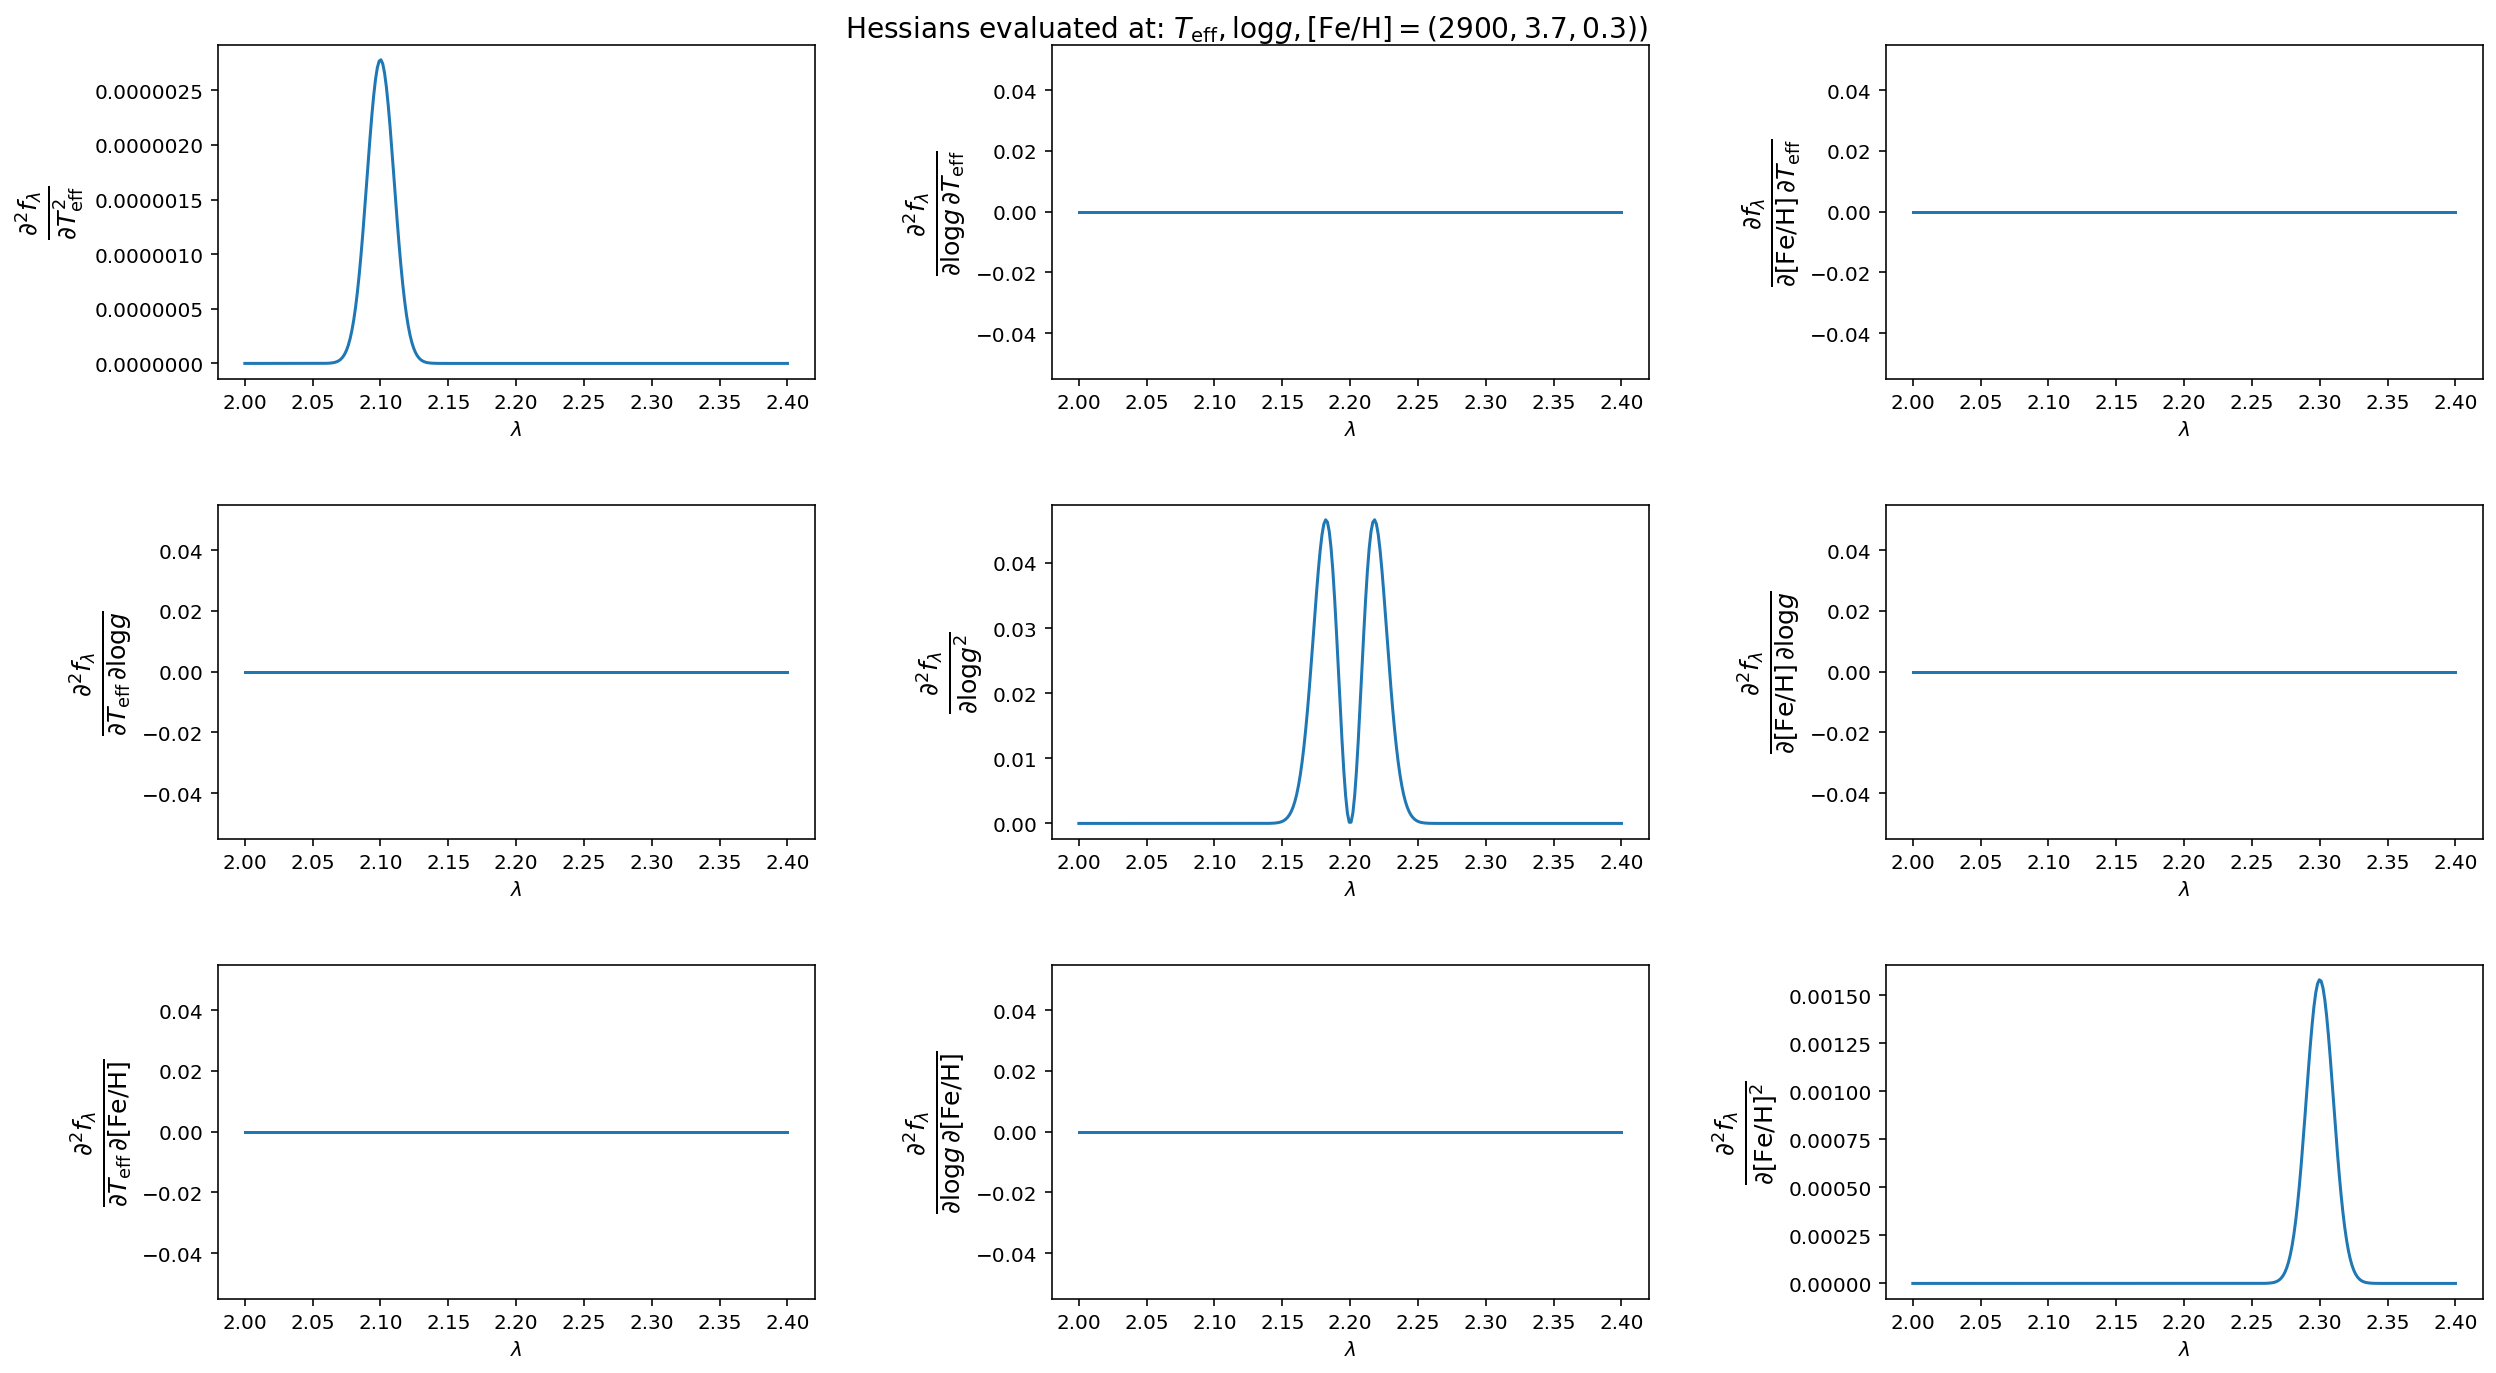

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
j=0
for i in range(3): 
    for j in range(3): 
        partial_derivative=hessian_fr[i][j]
        axes[i][j].plot(wl,partial_derivative, label = labels[i]);
        axes[i][j].set_xlabel('$\lambda$'); axes[i][j].set_ylabel(labels[i][j], fontsize=18) 
fig.suptitle('Hessians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (2900, 3.7, 0.3))$', fontsize=14)
plt.tight_layout(pad=3);

Awesome!  We computed exact Hessians!  Each plot shows the partial second derivative of the spectrum with respect to permutations of stellar parameter.  
This example isn't quite interesting since each spectral line depends only on one paramater in this first demo.  Let's look at the case where multiple effects contribute to multiple lines.

## What if a single spectral line depends on multiple stellar parameters, instead of just one?

In [13]:
def synthetic_spectrum_confounded(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 

    amp1 = 0.3*np.exp(-((teff-2700)/500)**2) + 0.1*np.sqrt(6+fe_h)
    width1 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line1 = line_profile(2.2, amp1, width1)
    
    net_flux = 1 - (line1)
    return net_flux

In [14]:
flux = synthetic_spectrum_confounded((2700, 3.5, 0.0))

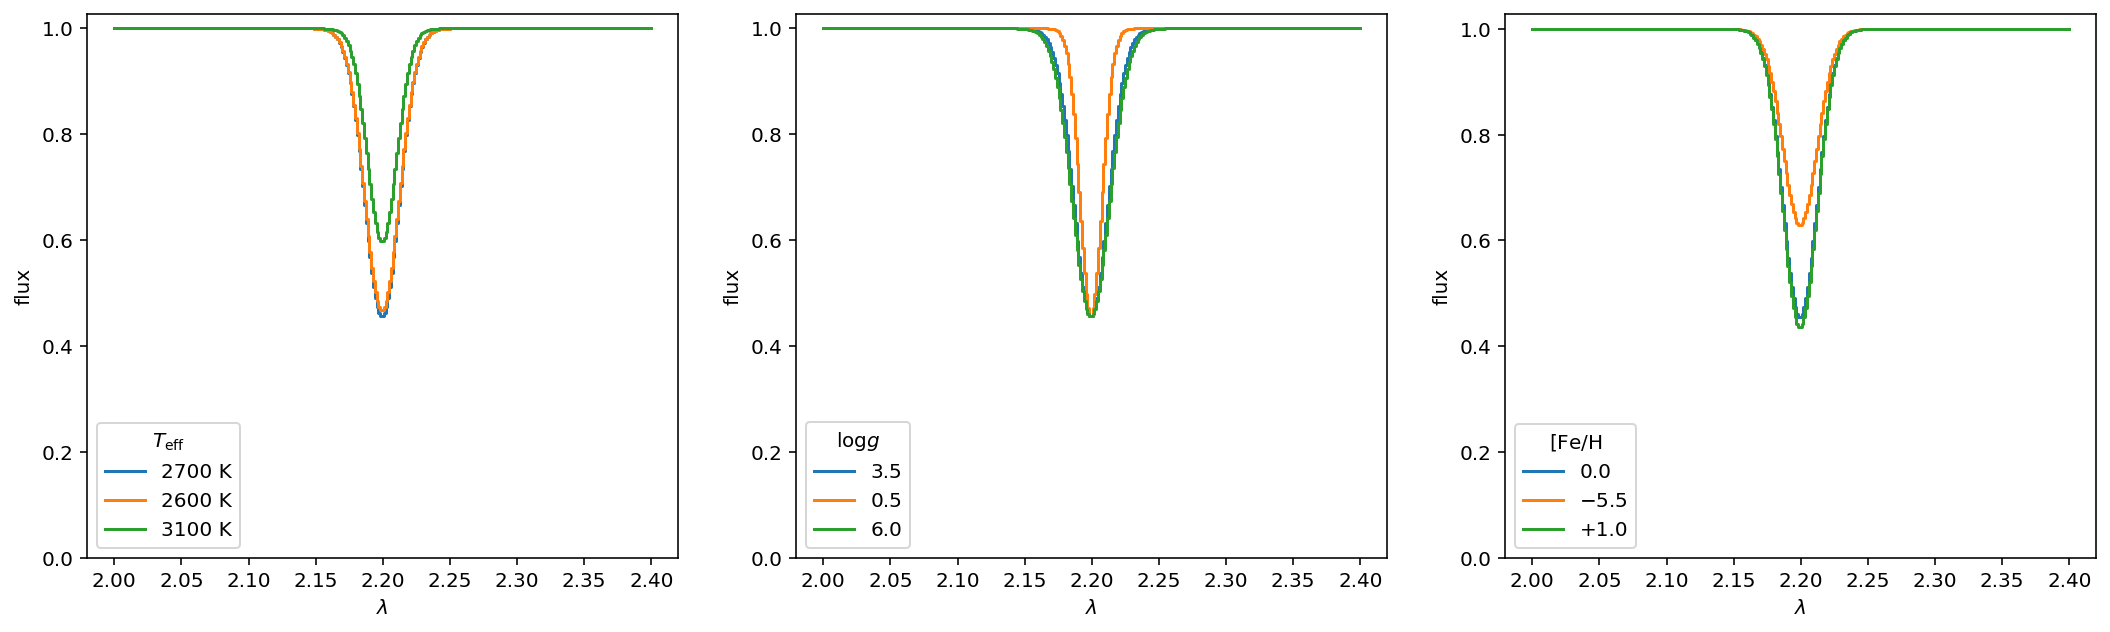

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].step(wl, flux, label='2700 K');
axes[0].step(wl, synthetic_spectrum_confounded((2600, 3.5, 0.0)), label='2600 K')
axes[0].step(wl, synthetic_spectrum_confounded((3100, 3.0, 0.0)), label='3100 K')
axes[0].set_xlabel('$\lambda$'); axes[0].set_ylabel('flux');axes[0].legend(loc='best', title='$T_{\mathrm{eff}}$');axes[0].set_ylim(0);

axes[1].step(wl, flux, label='3.5');
axes[1].step(wl, synthetic_spectrum_confounded((2700, 0.5, 0.0)), label='0.5')
axes[1].step(wl, synthetic_spectrum_confounded((2700, 6.0, 0.0)), label='6.0')
axes[1].set_xlabel('$\lambda$'); axes[1].set_ylabel('flux');axes[1].legend(loc='best', title='$\log{g}$');axes[1].set_ylim(0);


axes[2].step(wl, flux, label='0.0');
axes[2].step(wl, synthetic_spectrum_confounded((2700, 3.5, -5.5)), label='$-5.5$')
axes[2].step(wl, synthetic_spectrum_confounded((2700, 3.5, 1.0)), label='+1.0')
axes[2].set_xlabel('$\lambda$'); axes[2].set_ylabel('flux');axes[2].legend(loc='best', title='$[\mathrm{Fe}/\mathrm{H}$');axes[2].set_ylim(0);

Messy!  The line depends on all three parameters!  This scenario is common in astrophysics and more physically realistic.  
It's hard to tell the derivative from these visualizations alone.  Let's see the Jacobian!

In [16]:
%%time 
hessian_confounded = jacrev(jacfwd(synthetic_spectrum_confounded))((3100.0, 3.7, 0.1))

CPU times: user 155 ms, sys: 64.1 ms, total: 219 ms
Wall time: 126 ms


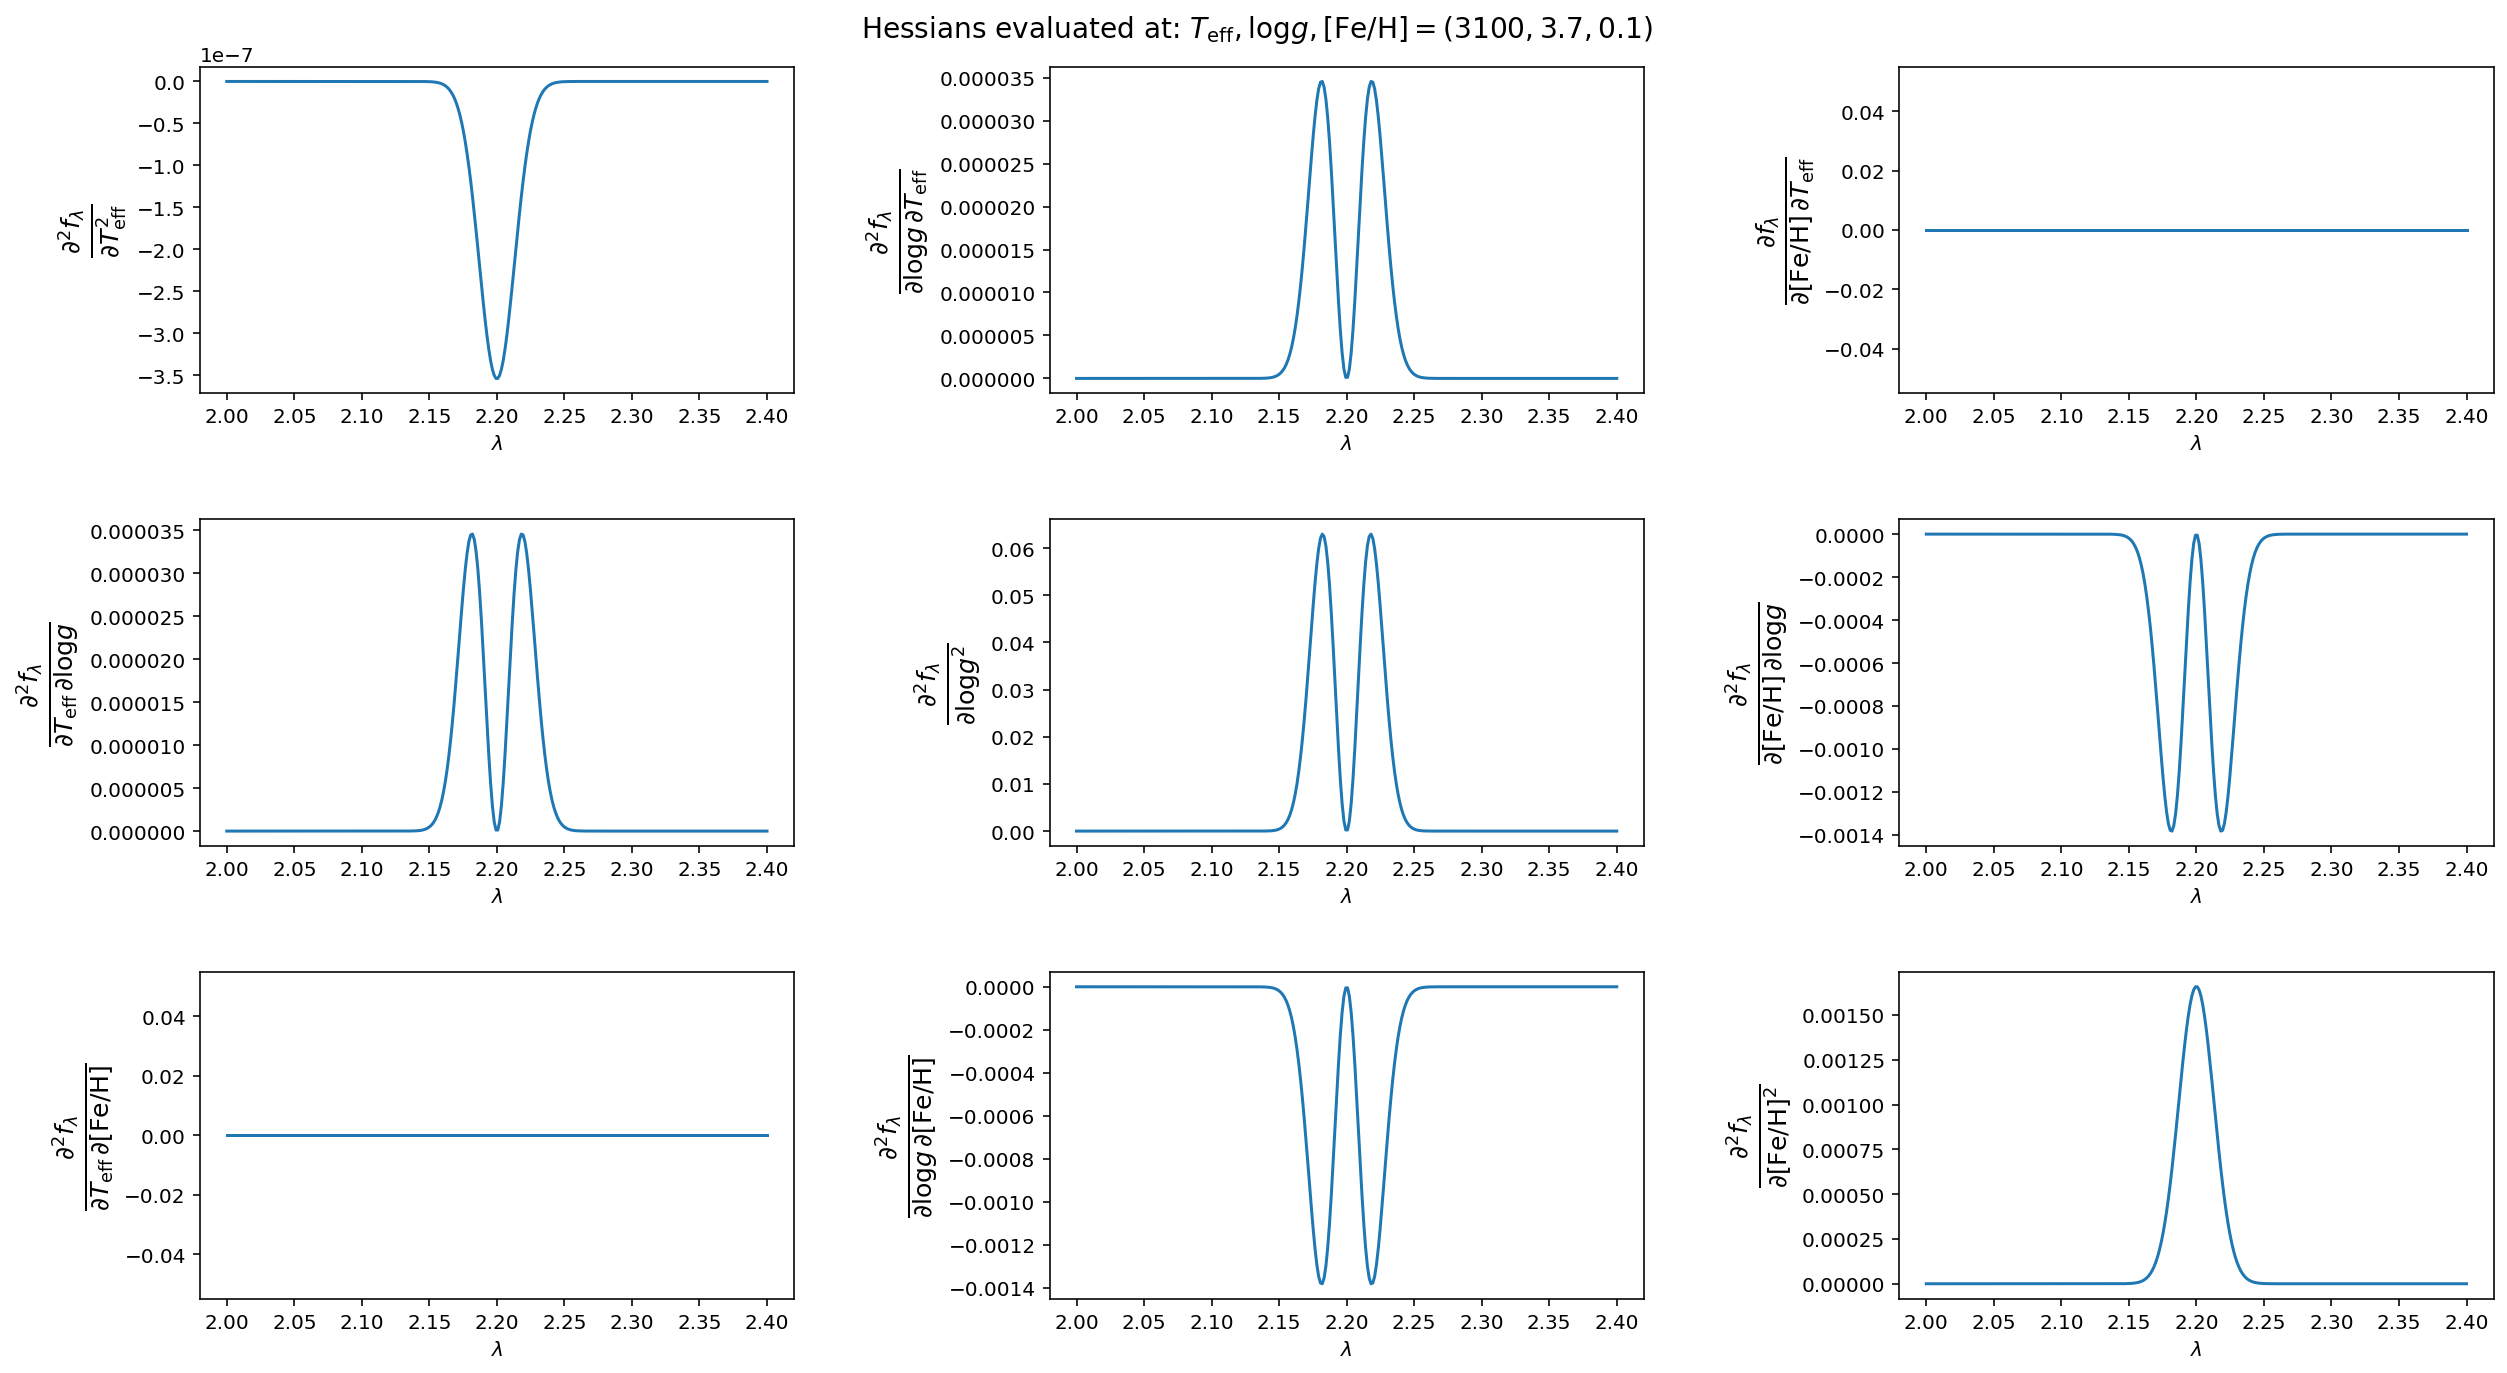

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
j=0
for i in range(3): 
    for j in range(3): 
        partial_derivative=hessian_confounded[i][j]
        axes[i][j].plot(wl,partial_derivative, label = labels[i]);
        axes[i][j].set_xlabel('$\lambda$'); axes[i][j].set_ylabel(labels[i][j], fontsize=18) 
fig.suptitle('Hessians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (3100, 3.7, 0.1)$', fontsize=14)
plt.tight_layout(pad=3);

Neat! We see that depending on multiple lines populates non-zero second derivatives for cross-terms.

Let's add the other lines back to see three lines, only one of which is confounded.

In [18]:
def synthetic_spectrum_mixed(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 

    amp1 = 0.6*np.exp(-((teff-2700)/500)**2)
    line1 = line_profile(2.1, amp1, 0.01)
    
    amp2 = 0.3*np.exp(-((teff-2700)/500)**2) + 0.1*np.sqrt(6+fe_h)
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, amp2, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

In [19]:
%%time 
hessian_mixed = jacrev(jacfwd(synthetic_spectrum_mixed))((3100.0, 3.7, 0.1))

CPU times: user 140 ms, sys: 65.3 ms, total: 206 ms
Wall time: 101 ms


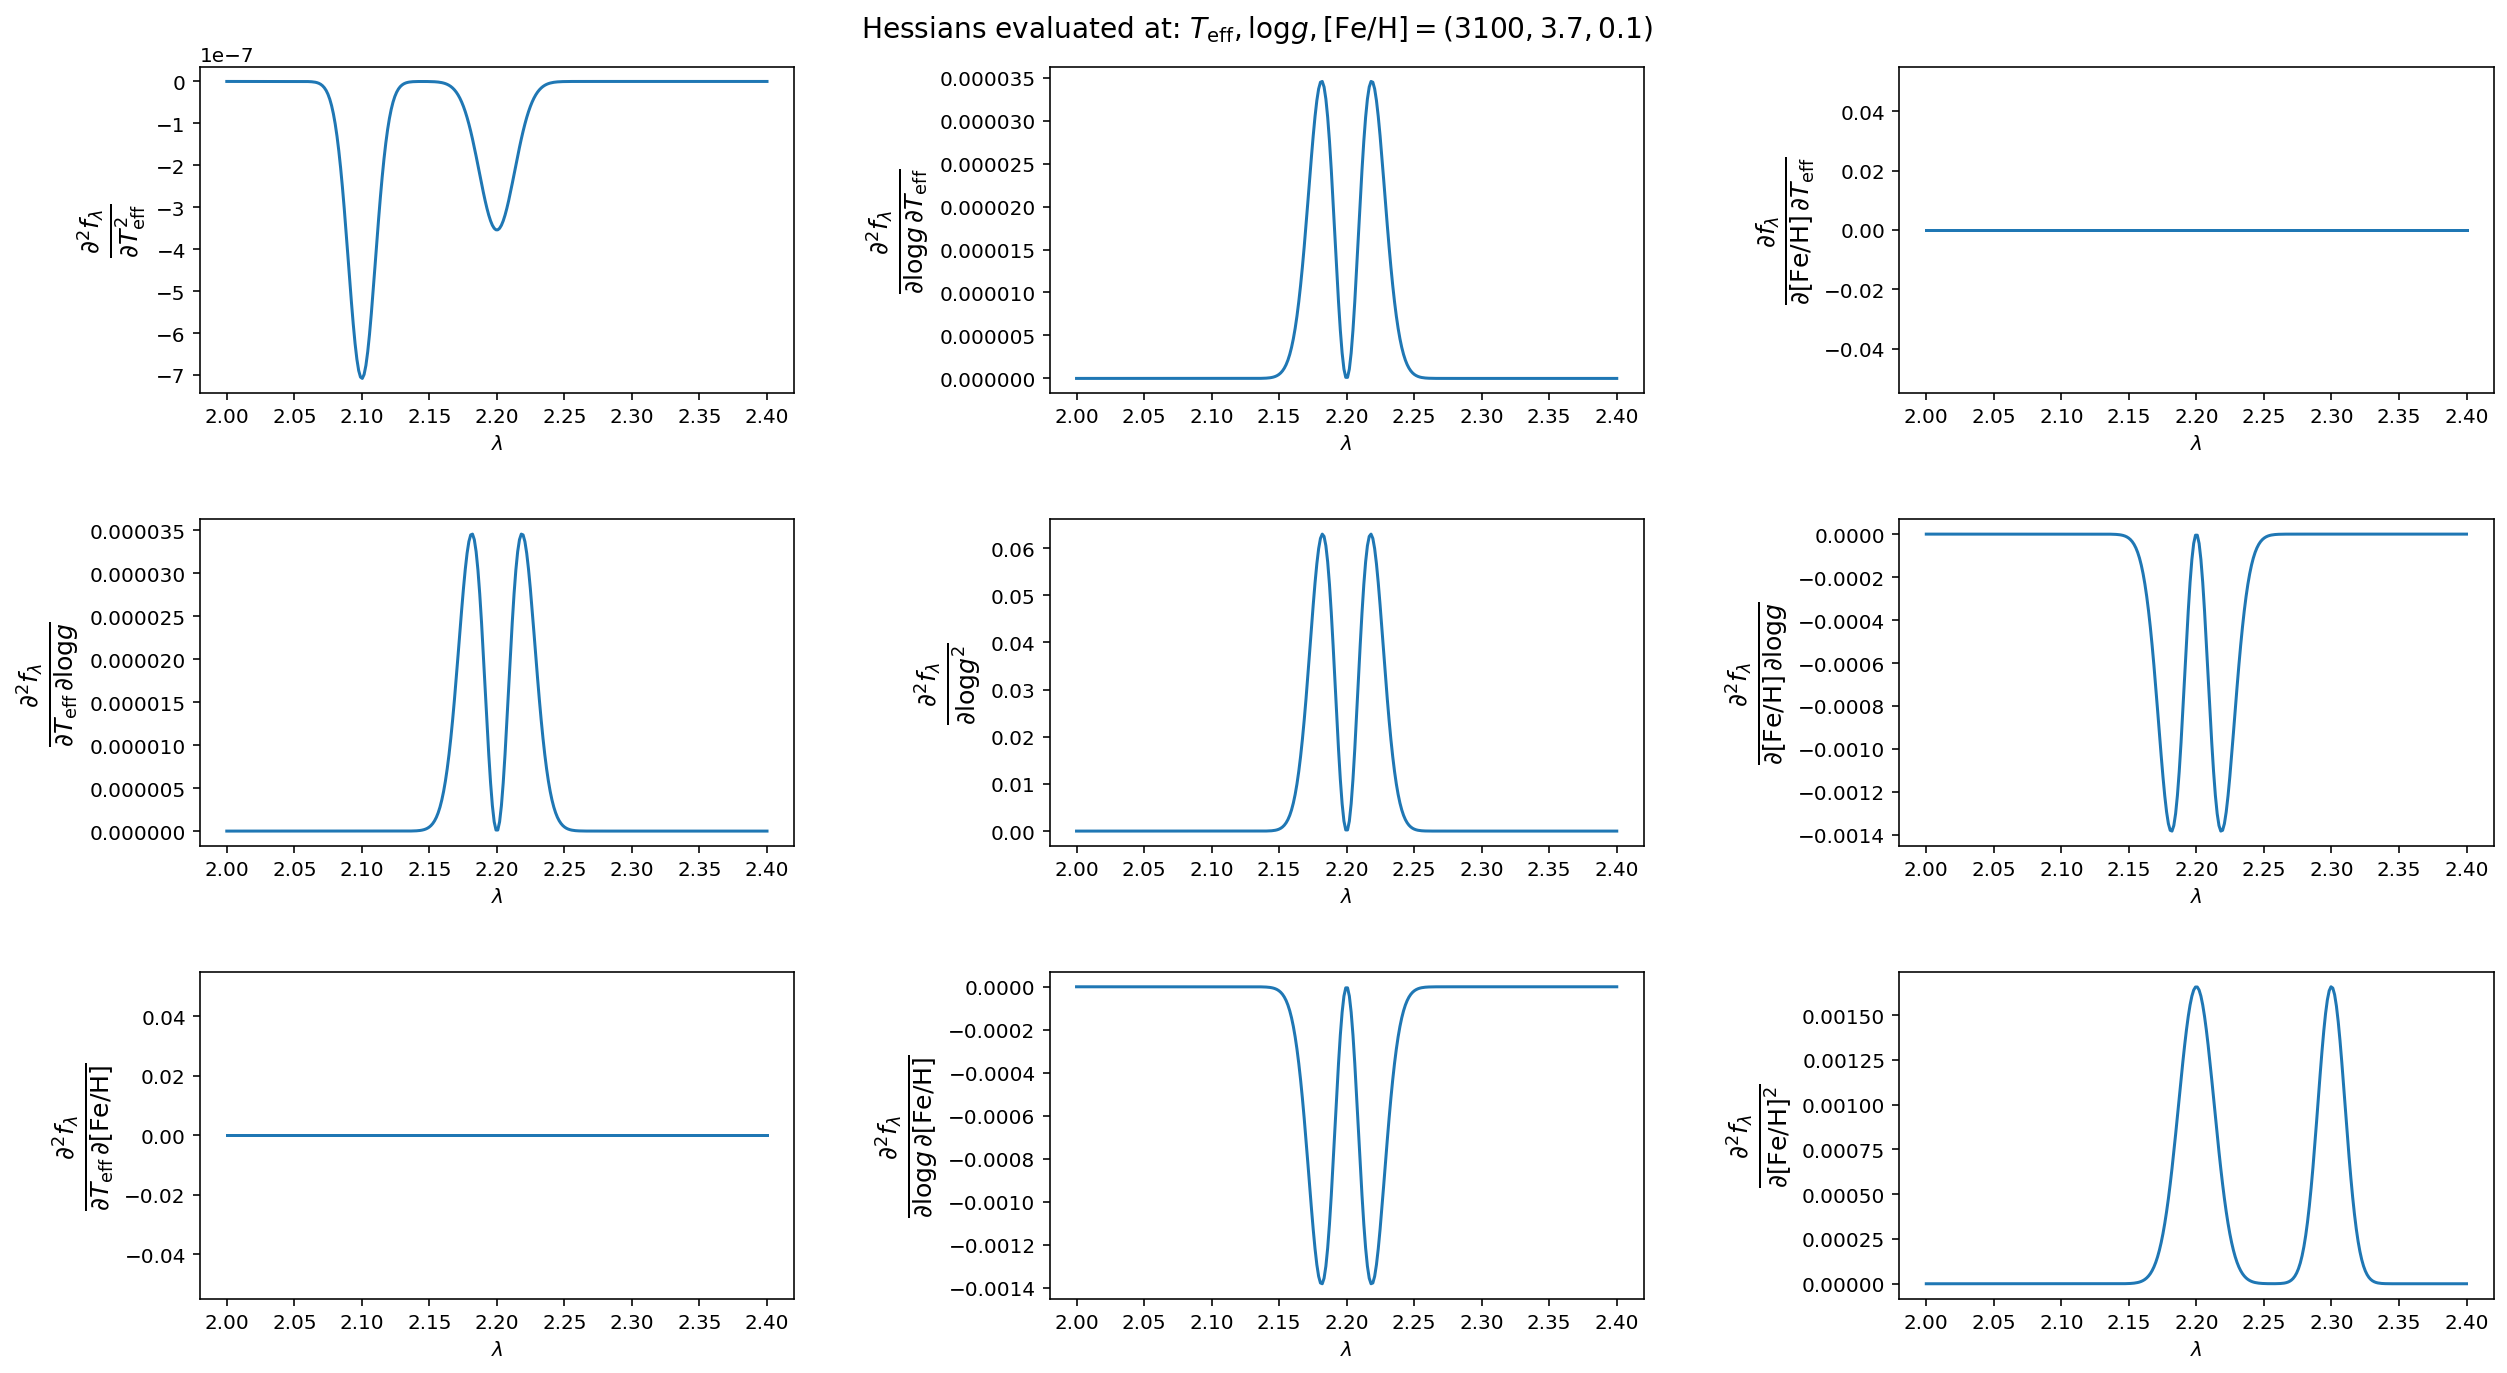

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
j=0
for i in range(3): 
    for j in range(3): 
        partial_derivative=hessian_mixed[i][j]
        axes[i][j].plot(wl,partial_derivative, label = labels[i]);
        axes[i][j].set_xlabel('$\lambda$'); axes[i][j].set_ylabel(labels[i][j], fontsize=18) 
fig.suptitle('Hessians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (3100, 3.7, 0.1)$', fontsize=14)
plt.tight_layout(pad=3);

Indeed, we see the diagonal terms retain the lines that depend on only one variable, while everything else is the same as the previouse example.

Finally we'll change things slightly again-- the line amplitude at 2.1 depends as the product of metallicity and Temperature.

In [21]:
def synthetic_spectrum_all(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 

    amp1 = 0.6*np.exp(-((teff-2700)/500)**2)*0.3*np.sqrt(6+fe_h)
    line1 = line_profile(2.1, amp1, 0.01)
    
    amp2 = 0.3*np.exp(-((teff-2700)/500)**2) + 0.1*np.sqrt(6+fe_h)
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, amp2, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

In [22]:
%%time 
hessian_all = jacrev(jacfwd(synthetic_spectrum_all))((3100.0, 3.7, 0.1))

CPU times: user 231 ms, sys: 97 ms, total: 327 ms
Wall time: 159 ms


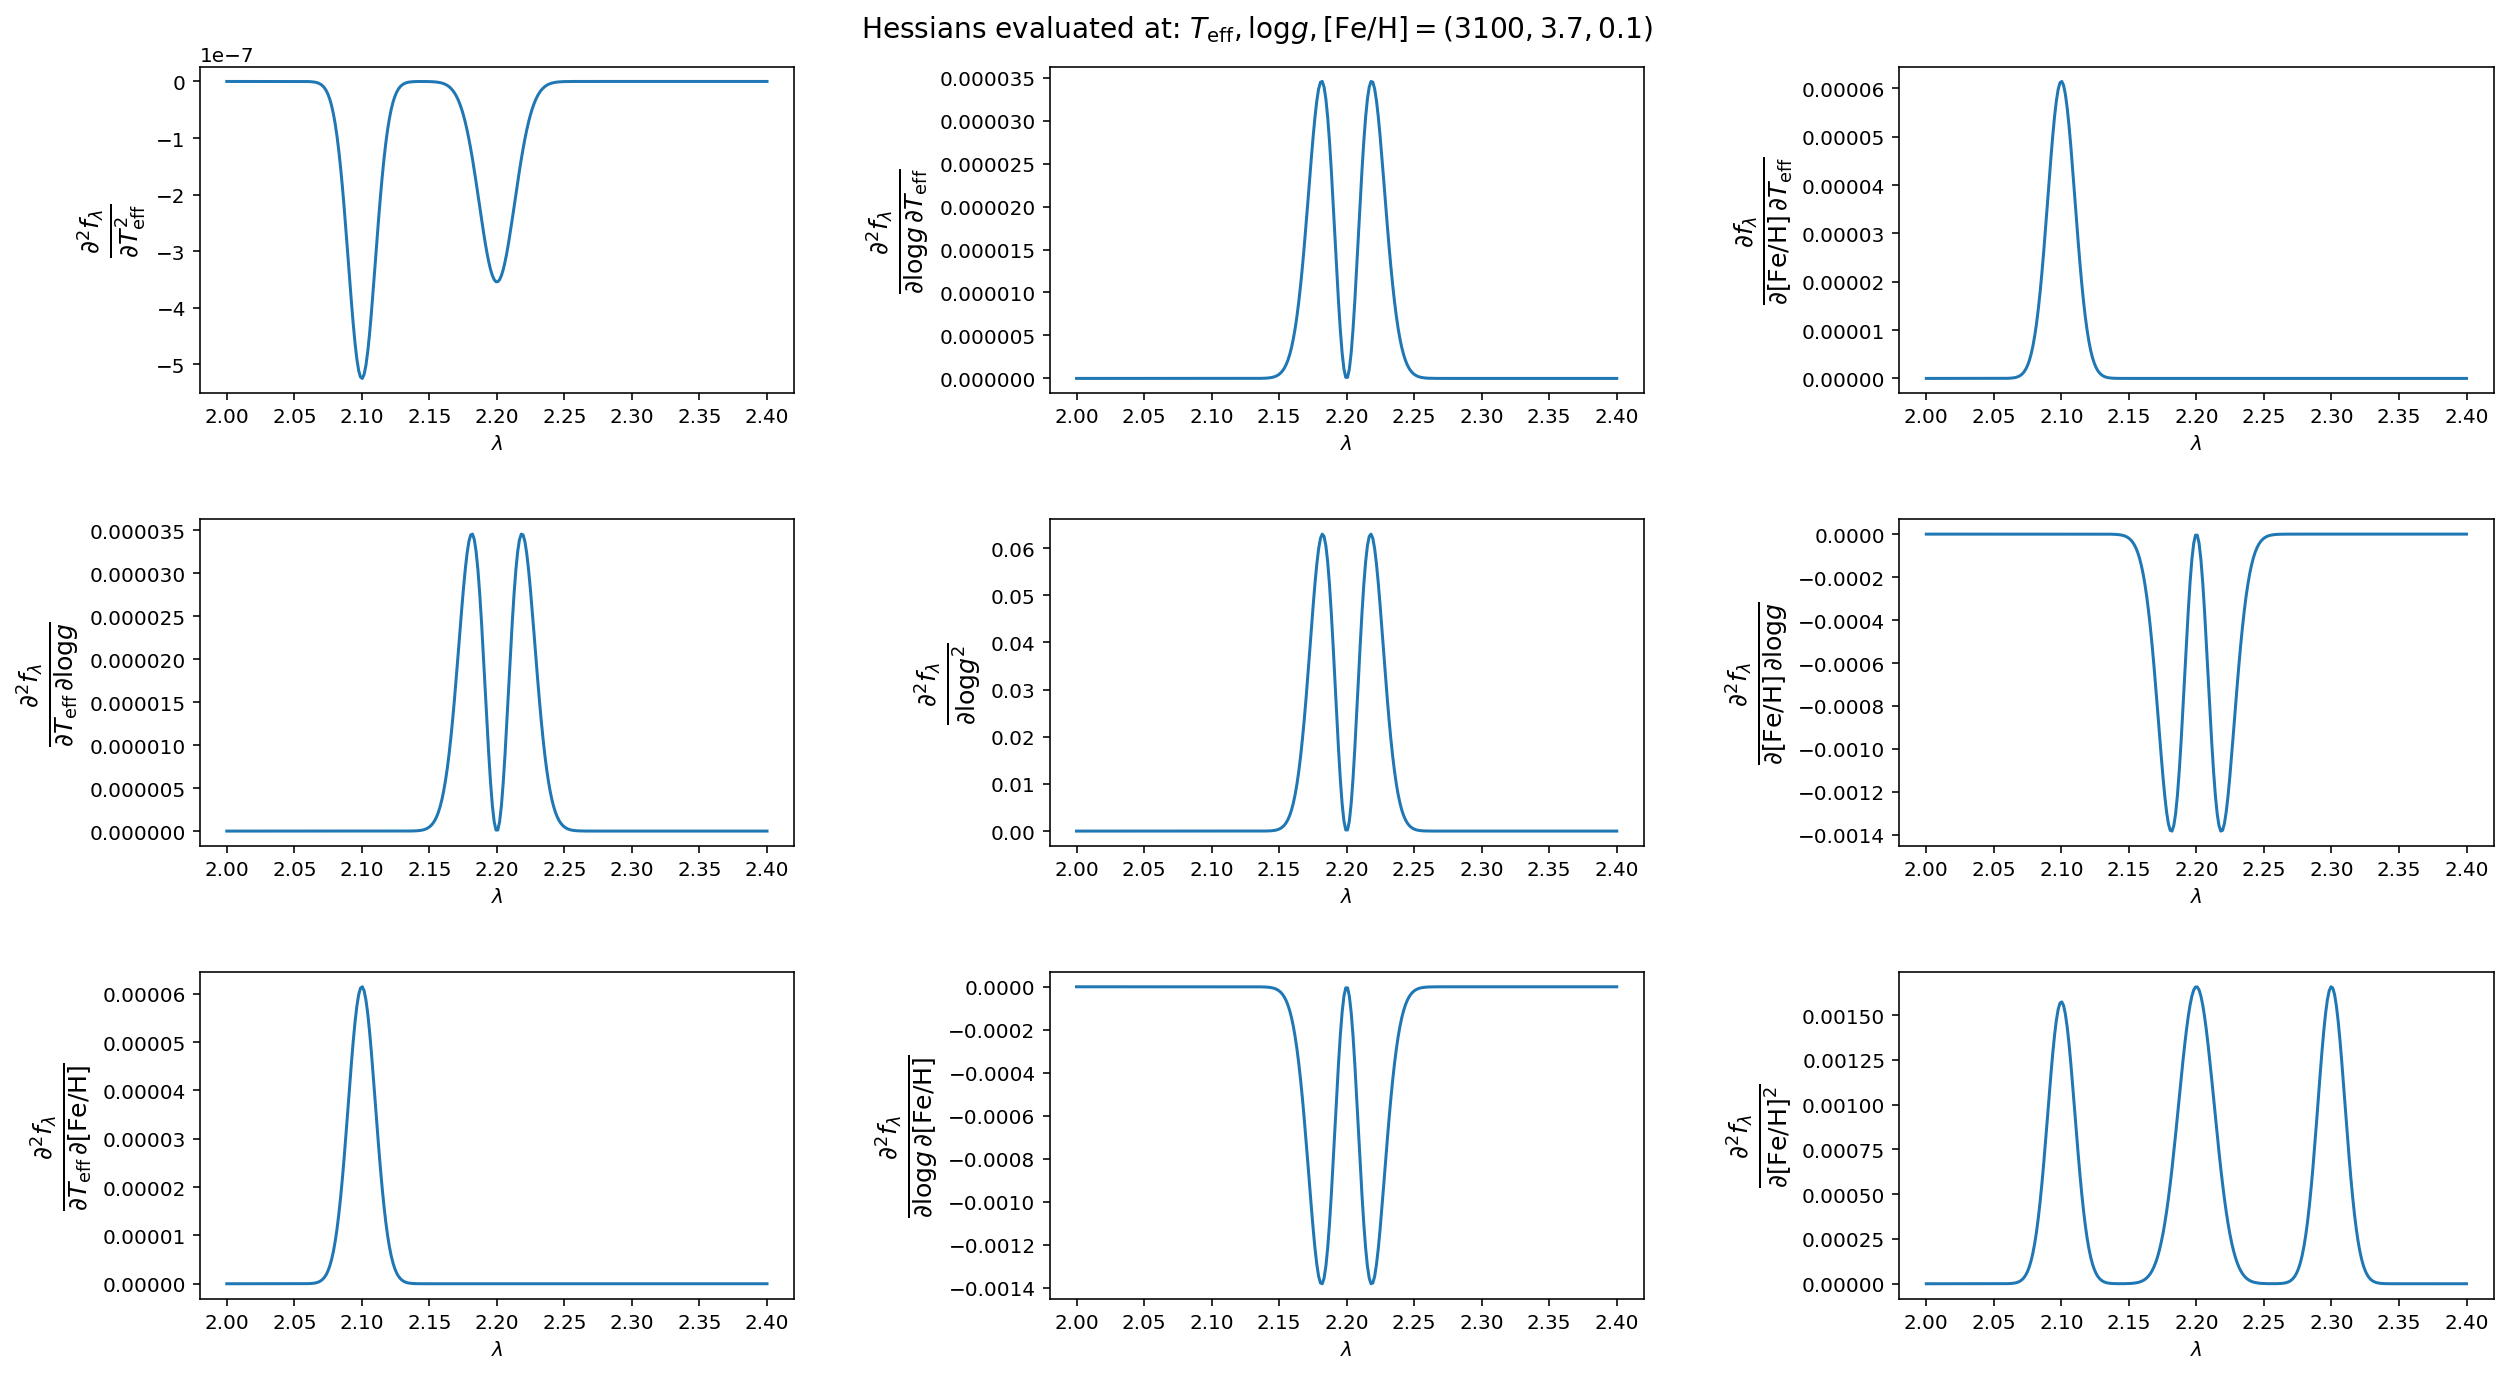

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
j=0
for i in range(3): 
    for j in range(3): 
        partial_derivative=hessian_all[i][j]
        axes[i][j].plot(wl,partial_derivative, label = labels[i]);
        axes[i][j].set_xlabel('$\lambda$'); axes[i][j].set_ylabel(labels[i][j], fontsize=18) 
fig.suptitle('Hessians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (3100, 3.7, 0.1)$', fontsize=14)
plt.tight_layout(pad=3);

Neat!  All permutations of parameters possess some line with second-order inter-dependence.  What happens if we look at exactly 2700 K?  That temperature coincides with when the amplitude is maximized for lines 1 and 2.  We'd expect to see that some permutations will go to zero, since the rate of change in temperature is zero.

In [24]:
%%time 
hessian_all = jacrev(jacfwd(synthetic_spectrum_all))((2700.0, 3.7, 0.1))

CPU times: user 142 ms, sys: 65.8 ms, total: 207 ms
Wall time: 105 ms


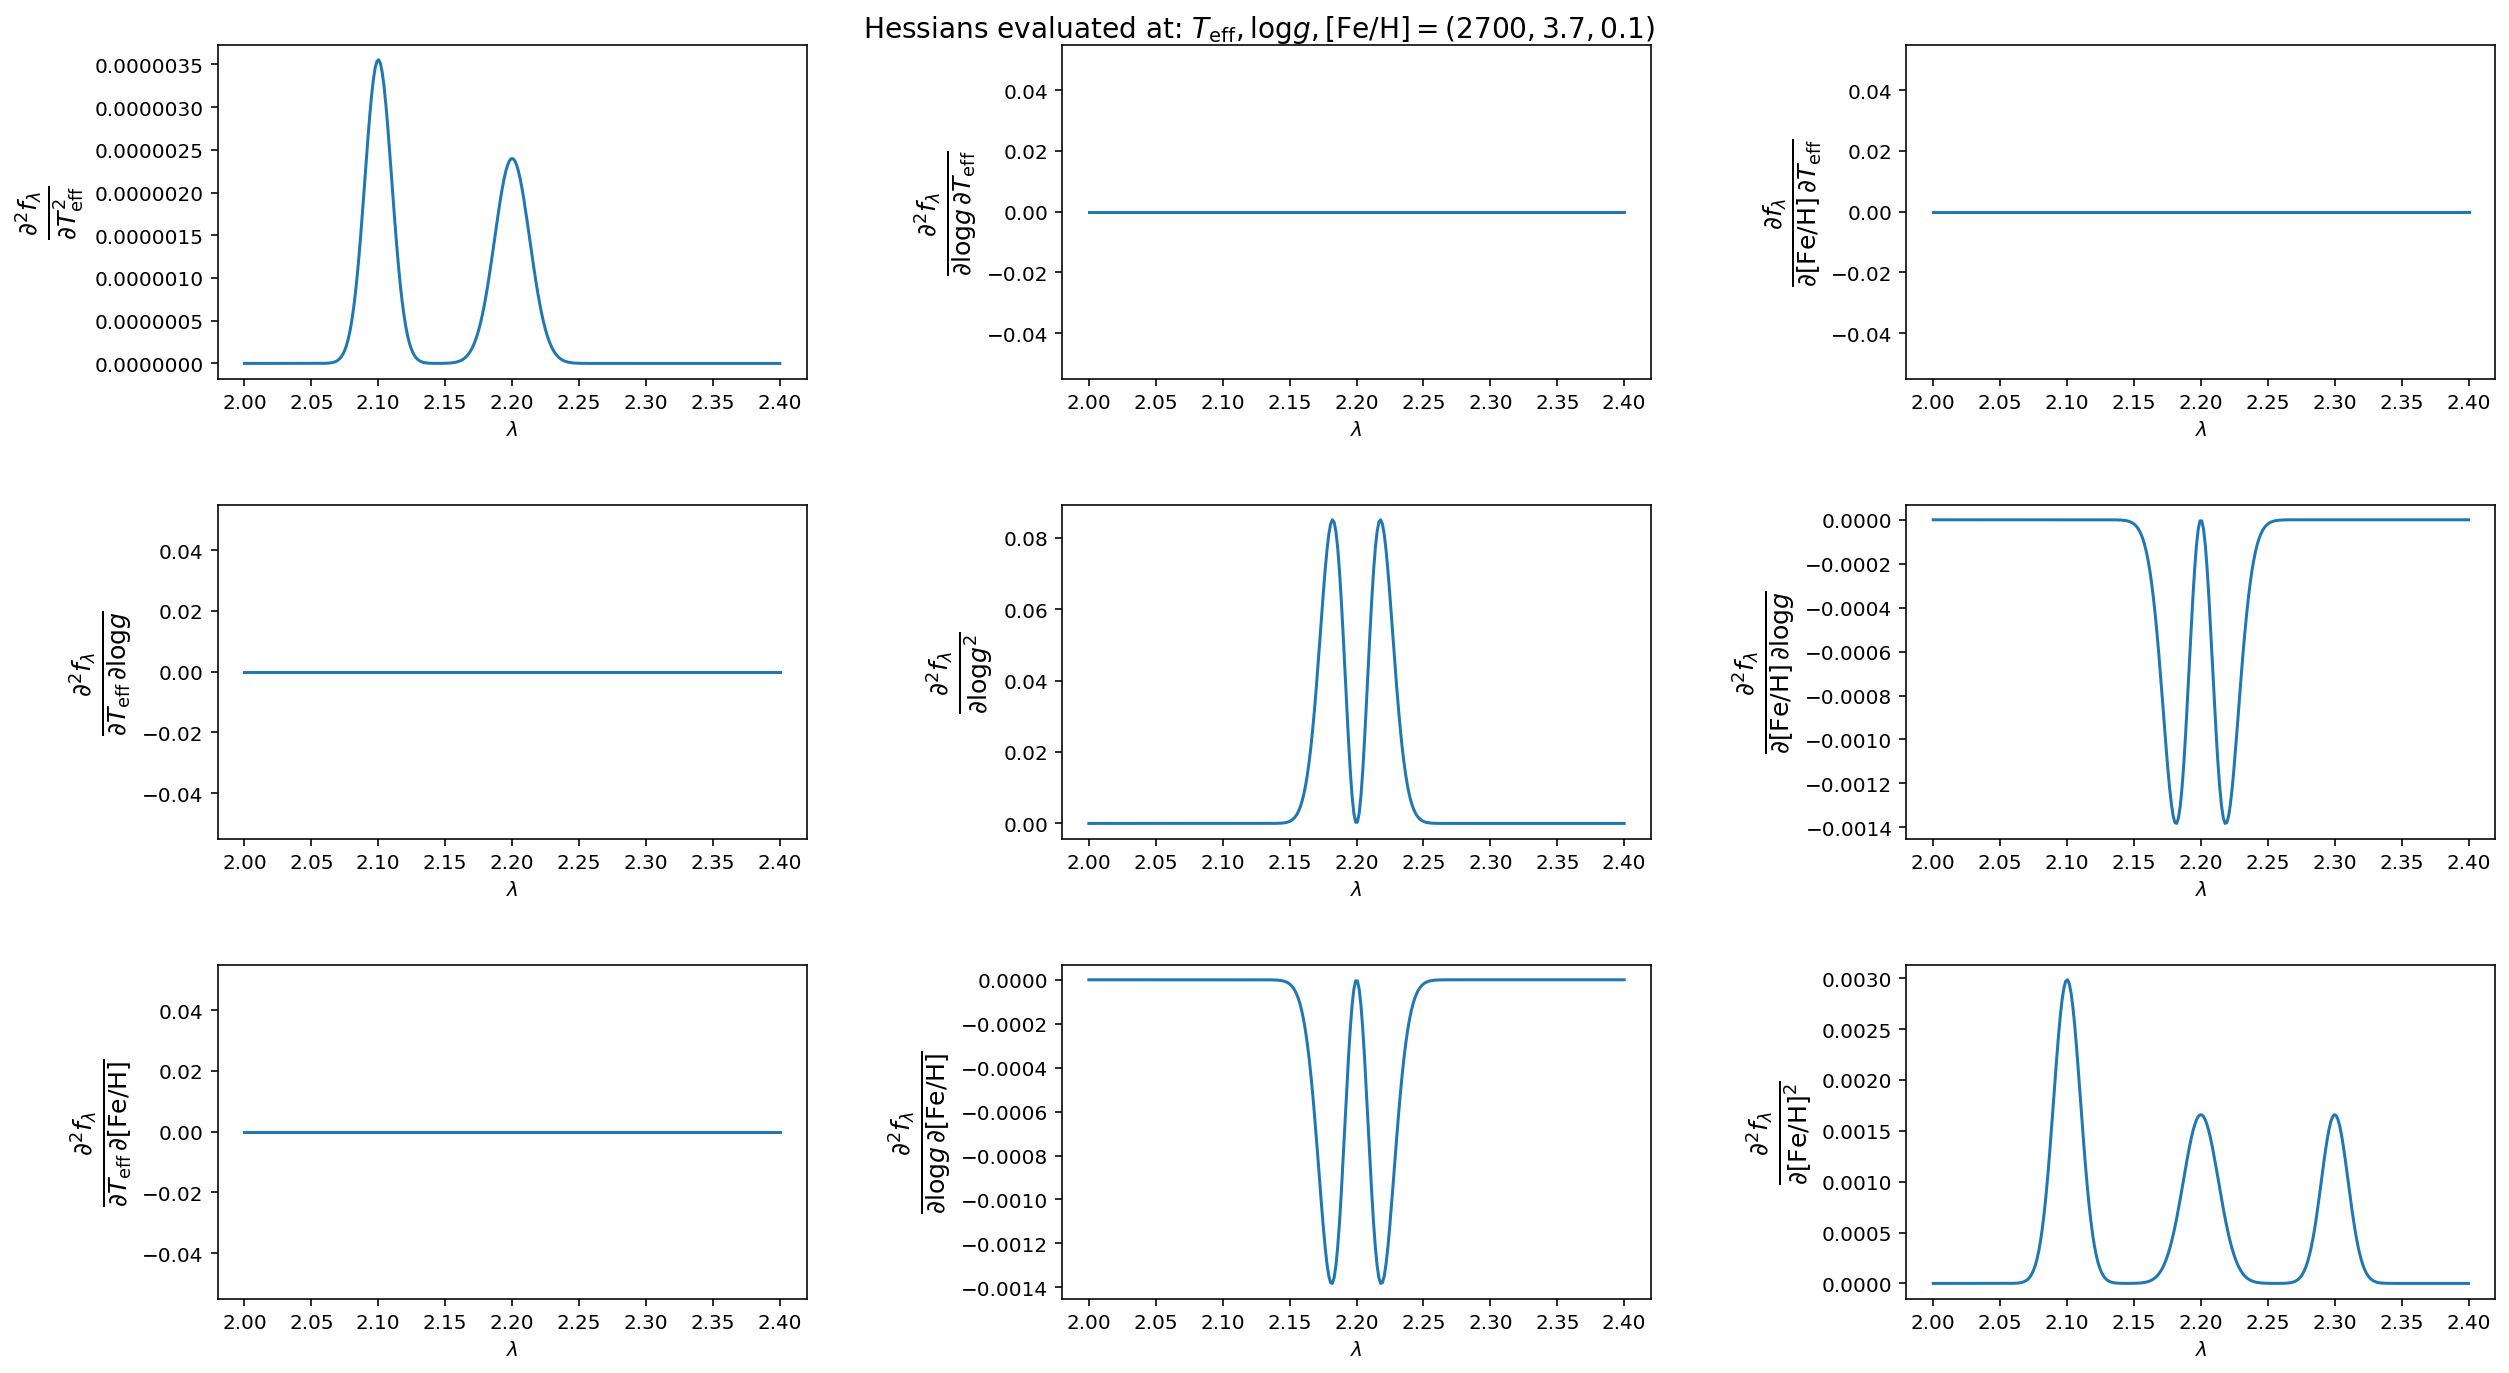

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
j=0
for i in range(3): 
    for j in range(3): 
        partial_derivative=hessian_all[i][j]
        axes[i][j].plot(wl,partial_derivative, label = labels[i]);
        axes[i][j].set_xlabel('$\lambda$'); axes[i][j].set_ylabel(labels[i][j], fontsize=18) 
fig.suptitle('Hessians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (2700, 3.7, 0.1)$', fontsize=14)
plt.tight_layout(pad=3);

Neat!  Indeed, we see that the slope with respect to Temperature is zero, so infinitesimal changes in temperature have no effect on the change in spectrum attributable to surface gravity.  I *think* what this means is that in a parameter *retrieval* exercise with weakly noisy data, we would expect to see little/degeneracy with gravity with temperature:  the uncertainty you conclude for logg is impervious to tiny changes to temperature.